## Introduction
####  Unsupervised learning on text difficulty

In [ ]:
# uncomment the following if the following packages have not been installed
#!pip install altair pyLDAvis tqdm dtale transformers spacy scattertext
#!pip install Flask==2.1.0
#!pip install sentence_transformers
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
#!pip3 install transformers
#!pip install tqdm

In [ ]:
# Disable warning of 3 types
import warnings
# Disable 3 types of warning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=(FutureWarning))
warnings.filterwarnings("ignore",category=(RuntimeWarning))

In [ ]:
from __future__ import print_function
import pandas as pd
import numpy as np

# Text preprocessing
import os,re

#Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import altair as alt
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


# Other utils
from tqdm import tqdm  # Progress bar
from datetime import datetime
from dateutil import parser

#EDA tools.
import dtale

# nlp text cleaning
import nltk
import re
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer # or LancasterStemmer, RegexpStemmer, SnowballStemmer

# Transformers
from transformers import pipeline
import ipywidgets as widgets
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# Clustering algorithms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer

# Visualizing text
import spacy
import scattertext

In [ ]:
%matplotlib inline

In [ ]:
# load training data
train_data_path="./01_data/WikiLarge_Train.csv"
train_data=pd.read_csv(train_data_path)

In [ ]:
len(train_data)

In [ ]:
train_data.head()

## Embedding-based clustering analysis

In [ ]:
onlinemodel='distiluse-base-multilingual-cased-v2'
embedder = SentenceTransformer(onlinemodel)

In [ ]:
#Create embeddings for data with label ==0
if os.path.exists("./tmp/embeddings_0.csv"):
    query_embeddings_0 = np.loadtxt("./tmp/embeddings_0.csv", delimiter=",")
else:
    # Sampling data given the full train data volume is big
    s_train=train_data.sample(n=round(len(train_data)*1))
    queries_0 = list(s_train[s_train['label']==0]['original_text'])
    query_embeddings_0=embedder.encode(queries_0)
    np.savetxt("embeddings_0.csv", query_embeddings_0, delimiter=",")

#Create embeddings for data with label ==1
if os.path.exists("./tmp/embeddings_1.csv"):
    query_embeddings_1 = np.loadtxt("./tmp/embeddings_1.csv", delimiter=",")
else:
    # Sampling data given the full train data volume is big
    s_train=train_data.sample(n=round(len(train_data)*1))
    queries_1 = list(s_train[s_train['label']==1]['original_text'])
    query_embeddings_1=embedder.encode(queries_1)
    np.savetxt("embeddings_1.csv", query_embeddings_1, delimiter=",")

In [64]:
# Create the mapping df between difficult text with easy one
df_text=pd.DataFrame(columns=["queries_1","embeddings_1","queries_0","embeddings_0","sim"])
for i in tqdm(range(len(query_embeddings_1[0:99]))):
    sim=cosine_similarity([query_embeddings_1[i]],query_embeddings_0)
    j=np.argmax(sim)
    new_row=pd.Series(data={"queries_1":queries_1[i],
                            "embeddings_1":query_embeddings_1[i],
                            "queries_0":queries_0[j],
                            "embeddings_0":query_embeddings_0[j],
                            "sim":sim[0][j]
                           }
                            )
    df_text=df_text.append(new_row,ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [01:16<00:00,  1.29it/s]


In [69]:
df_text

,queries_1,embeddings_1,queries_0,embeddings_0,sim
0,La Jaiba -LRB- D.M. -RRB-,"[0.021947026, 0.008795212, 0.009067205, -0.000...",La Jaiba -LRB- M.D. -RRB-,"[0.02456008, 0.008722366, 0.006629037, 0.00120...",0.998213
1,"Early life Cheadle was born in Kansas City , M...","[0.00040435168, -0.021138217, -0.017045658, -0...",He became a professor of psychiatry at New Yor...,"[-0.01821696, -0.017677804, -0.017193617, -0.0...",0.557918
2,"Carol Ann Duffy , CBE , FRSL -LRB- born 23 Dec...","[-0.03793011, -0.06298795, -0.0082166465, 0.01...","Carol Ann Duffy , -LRB- born 23 December 1955 ...","[-0.03759245, -0.05048594, -0.0034072765, -0.0...",0.869363
3,The outermost regular satellite Callisto is lo...,"[-0.007885038, 0.027289204, 0.03829903, 0.0006...",The farthest spherical moon Callisto is locate...,"[0.0032394158, 0.011456954, 0.06295828, 0.0226...",0.631663
4,History of the Schulze method The Schulze meth...,"[-0.04084515, 0.024551671, 0.051712267, -0.040...",It was developed in 1997 by Markus Schulze .,"[0.0046825497, 0.004328504, 0.008689318, -0.01...",0.785267
...,...,...,...,...,...
94,When Buick designed a 90 Â V6 based on their 9...,"[0.007864278, 0.051679082, -0.0010301737, 0.02...","The first Buick V6 was a 90 Â , based on their...","[-0.0009328814, 0.03766972, -0.040457822, 0.01...",0.595496
95,Implementation can be further broken down into...,"[0.013359765, -0.06491709, 0.056211904, -0.001...",Implementation can be further broken down into...,"[0.0040647476, -0.06198022, 0.015356637, -0.00...",0.839427
96,"The next day , Stoneman and his cavalry went i...","[0.021934763, -0.000893814, -0.07537996, -0.01...","The next day , Stoneman and his cavalry went i...","[0.024207558, -0.0011593106, -0.07528099, -0.0...",0.999045
97,The Super Nintendo Entertainment System or Sup...,"[-0.013279265, -0.03485045, -0.020644603, -0.0...",The Super Nintendo Entertainment System -LRB- ...,"[0.0073274113, -0.060050204, 0.0013010709, -0....",0.836428


In [ ]:
# Elbow criterion - Determine optimal numbers of clusters by elbow rule.
def elbow_plot(data, maxK=15, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = []
    K= range(1, maxK)
    for k in K:
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            #data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            #data["clusters"] = kmeans.labels_
        print("k: ", k,"sse: ",kmeans.inertia_)
        # Inertia: Sum of distances of samples to their closest cluster center
        sse.append(kmeans.inertia_)
    plt.figure()
    plt.plot(K,sse,'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return kmeans.labels_

# Run Elbow
elbow_plot(query_embeddings_0,maxK=5)

In [51]:
num_clusters = 4
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(query_embeddings_0)
cluster_assignment = clf.labels_

cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":queries_0[i]
                           }
                            )
    cdf=cdf.append(new_row,ignore_index=True)

cdf.head()

,cluster_id,sentence_id,sentence
0,2,0,The largest bodies of salt water are the oceans .
1,3,1,It contains the following municipalities :
2,0,2,When she later died she was buried in her wedd...
3,1,3,"Universal features , such as the -LRB- which l..."
4,2,4,"Kremnica , Slovakia"


In [58]:
num_clusters = 4
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(query_embeddings_1)
cluster_assignment = clf.labels_

cdf_1=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":queries_1[i]
                           }
                            )
    cdf_1=cdf_1.append(new_row,ignore_index=True)

cdf_1.head()

,cluster_id,sentence_id,sentence
0,3,0,La Jaiba -LRB- D.M. -RRB-
1,2,1,"Early life Cheadle was born in Kansas City , M..."
2,3,2,"Carol Ann Duffy , CBE , FRSL -LRB- born 23 Dec..."
3,0,3,The outermost regular satellite Callisto is lo...
4,2,4,History of the Schulze method The Schulze meth...


In [52]:
# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(query_embeddings_0)

df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca['sentence']=queries_0
# Combine PCA results with K-means results to see clustering
df_k=df_pca.merge(cdf,right_on=['sentence'],left_on=['sentence'])

In [59]:
# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca_1 = PCA(n_components=2)
principalComponents = pca_1.fit_transform(query_embeddings_1)

df_pca_1 = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca_1['sentence']=queries_1
# Combine PCA results with K-means results to see clustering
df_k_1=df_pca_1.merge(cdf,right_on=['sentence'],left_on=['sentence'])

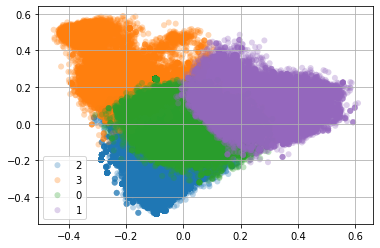

In [57]:
fig, ax = plt.subplots()
ls_clusters=pd.unique(df_k["cluster_id"])
ls_colors=['tab:blue', 'tab:orange', 'tab:green','tab:purple']
for id in range(len(ls_clusters)):
    ax.scatter(df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 1'],
               df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 2'], c=ls_colors[id], label=ls_clusters[id],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

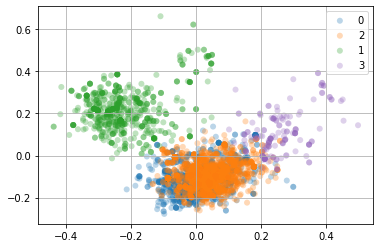

In [60]:
fig, ax = plt.subplots()
ls_clusters=pd.unique(df_k_1["cluster_id"])
ls_colors=['tab:blue', 'tab:orange', 'tab:green','tab:purple']
for id in range(len(ls_clusters)):
    ax.scatter(df_k_1[df_k_1['cluster_id']==ls_clusters[id]]['principal component 1'],
               df_k_1[df_k_1['cluster_id']==ls_clusters[id]]['principal component 2'], c=ls_colors[id], label=ls_clusters[id],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

In [ ]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(df_pca['sentence'])
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df_pca['sentence'])

In [ ]:
# Using LDA to cluster skills
lda_tf = LatentDirichletAllocation(n_components=3, random_state=0)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=3, random_state=0)
lda_tfidf.fit(dtm_tfidf)

In [ ]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [ ]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [ ]:

stemmer = SnowballStemmer("english")
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [ ]:
# At this point we are going to tokenize the bodies and convert them
# into a document-term matrix.

# Some note on min_df and max_df
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"
stopwords = ENGLISH_STOP_WORDS.union(['data','scientist'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.5, min_df=2,use_idf=True,max_features=200000, 
                       tokenizer=tokenize_only,ngram_range=(1,3))

X = vect.fit_transform(df_tk['titles'].values)
print(X.shape)
features = vect.get_feature_names()

In [ ]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(15, 9+len(dfs)*6), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(len(dfs),3, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [ ]:
#Use this to print the top terms per cluster with matplotlib.
plot_tfidf_classfeats_h(top_feats_per_cluster(X, t_clf.labels_, features, 0.1, 25))

In [ ]:
# The above is more than clear, the tiltes are consisted of 3 types: junior, senior, and others

In [ ]:
# Perform EDA to check main table
d3 = dtale.show(df_tk)
d3.open_browser()

In [ ]:
# Decide to divide the job postings into 3 types:junior, senior, and others
def ds_level(title=''):
    jr = ["junior", "jr", "jr.","intern","internship","young","student","analyst","associate"]
    sr = ["sr.","sr","senior","lead","leading","principal","president"]

    if any(x in title.lower() for x in jr):
        return "junior"

    if any(x in title.lower() for x in sr):
        return "senior"
    
    return "others"


In [ ]:
df_skills

In [ ]:
df_main['type']=df_main['title'].apply(lambda x: ds_level(x))

In [ ]:
df_main['id']=df_main['id'].astype('int64')

In [ ]:
df_full=df_skills.merge(df_main,how='left',left_on=['id'],right_on=['id'])

In [ ]:
# Perform EDA to check main table
d4 = dtale.show(df_full)
d4.open_browser()

In [ ]:
# Using scattertext to visualize the skills by types
nlp = spacy.load('en_core_web_sm')

In [ ]:
    corpus = (scattertext.CorpusFromPandas(df_full,
                                           category_col='type', 
                                           text_col='skill',
                                           nlp=nlp)
              .build()
              .remove_terms(nlp.Defaults.stop_words, ignore_absences=True)
              )

In [ ]:
df = corpus.get_term_freq_df()

In [ ]:
df

In [ ]:
html = scattertext.produce_scattertext_explorer(
                   corpus,
                   category='senior',
                   category_name='senior',
                   not_category_name=['junior'],
                   width_in_pixels=1000,
                   )

In [ ]:
#open("ds_skills.html", 'wb').write(html.encode('utf-8'))
#with open("ds_skills.html", 'w') as outf: outf.write(html)
from IPython.display import IFrame    
display(IFrame("ds_skills.html", width=900, height=650))

In [ ]:

# data clean for data jobs
data_file= './01_Data/Output/datajobs.csv'
df_data=pd.read_csv(data_file)
# Drop the duplicated job postings 
df_data.drop_duplicates(subset=['employer','description','title','location'],inplace=True)
# Drop the job posting with same id even the above would be a little different.
df_data.drop_duplicates(subset=['id'],inplace=True)
# drop na
df_data.dropna(subset=['description'],inplace=True)
# Change string to datetime
df_data['posting_date']=df_data['posting_date'].apply(lambda x: parser.parse(x))

In [ ]:
#remove data scientists job from data jobs
print(len(df_data))
ds_list=df_main['id'].unique()
df_data['id']=df_data['id']=df_data['id'].apply(lambda x: None if x in (ds_list) else x)
df_data.dropna(subset=['id'],inplace=True)
print(len(df_data))

In [ ]:
# Convert titles to embedding
titles = list(df_data['title'].unique())
titles_embeddings = embedder.encode(titles)

In [ ]:
# Run Elbow to decide K for k-means
elbow_plot(titles_embeddings,maxK=8)

In [ ]:
# As clustering algorithm KMeams is a perfect fit.
num_clusters = 3
t_clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
t_clf.fit_predict(titles_embeddings)
t_cluster_assignment = t_clf.labels_

t_cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(t_cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":t_cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":titles[i]
                           }
                            )
    t_cdf=t_cdf.append(new_row,ignore_index=True)

t_cdf.head()

In [ ]:
# Using PCA to reduce the dimension to project the result to 2-d scatter plot

t_pca = PCA(n_components=2)
t_principalComponents = t_pca.fit_transform(titles_embeddings)


df_tpca = pd.DataFrame(data = t_principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_tpca['titles']=titles

In [ ]:
# Combine PCA results with K-means results to see clustering
df_tk=df_tpca.merge(t_cdf,right_on=['sentence'],left_on=['titles'])

In [ ]:
# At this point we are going to tokenize the bodies and convert them
# into a document-term matrix.

# Some note on min_df and max_df
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"
stopwords = ENGLISH_STOP_WORDS.union(['data','scientist'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.5, min_df=2,use_idf=True,max_features=200000, 
                       tokenizer=tokenize_only,ngram_range=(1,3))

X = vect.fit_transform(df_tk['titles'].values)
print(X.shape)
features = vect.get_feature_names()

In [ ]:
    height=600
    width=800
    # Create scatter plot to display death and confirmed cases by countries
    tscat=alt.Chart(df_tk).mark_circle(size=100).encode(
        y=alt.Y("principal component 1", axis=alt.Axis(format='f', title='PC 1')),
        x=alt.X("principal component 2",axis=alt.Axis(format='f', title='PC 2')),
        #color=alt.condition(select_country,alt.value("red"),alt.value("#66B2FF")),
        color=alt.Color('cluster_id', scale=alt.Scale(scheme='accent')),
        tooltip=["titles"]
    ).properties(
        height=height, width=width,
        title = alt.TitleParams(text = 'Clusters of titles',
                                anchor='middle',
                                font = 'Ubuntu Mono', 
                                fontSize = 16, 
                                color = '#3E454F', 
                                )
    )
    tscat

In [ ]:
#Use this to print the top terms per cluster with matplotlib.
plot_tfidf_classfeats_h(top_feats_per_cluster(X, t_clf.labels_, features, 0.1, 25))

In [ ]:
# Select data scientist jobs
print(len(df_data))
df_de=df_data[df_data['title'].str.contains(r'^(?=.*data)(?=.*engineer)',case=False)]
print(len(df_de))